# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

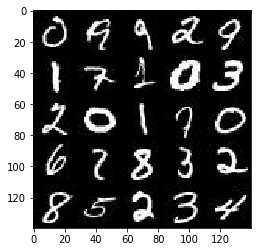

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

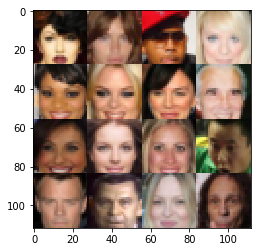

In [3]:
show_n_images = 16

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [9]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="inputs_real")
    inputs_z = tf.placeholder(tf.float32, (None,z_dim), name="inputs_z")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [26]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    #parameters
    kernel_size = 3
    alpha = 0.15
    
#     norm_inputs = tf.nn.l2_normalize(images,0)
    
    with tf.variable_scope("discriminator", reuse=reuse) as discriminator_scope:
        
        
        #input shape is 28x28x5
        input_layer1 = tf.layers.conv2d(images, 64, kernel_size=3, strides=2, padding='same')
        relu1 = tf.maximum(alpha * input_layer1, input_layer1) 
        #shape is now 14x14x64
        
        input_layer2 = tf.layers.conv2d(input_layer1, 128, kernel_size=3, strides=2, padding='same')
        batch_norm2 = tf.layers.batch_normalization(input_layer2, training=True)
        relu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        #shape is now 7x7x128
        
        input_layer3 = tf.layers.conv2d(input_layer2, 256, kernel_size=5, strides=1, padding='same')
        batch_norm3 = tf.layers.batch_normalization(input_layer3, training=True)
        relu3 = tf.maximum(alpha * batch_norm3, batch_norm3) 
#         shape is now 7x7x256
        
#         input_layer4 = tf.layers.conv2d(input_layer3, 512, kernel_size, strides=1, padding='same')
#         batch_norm4 = tf.layers.batch_normalization(input_layer4, training=True)
#         relu4 = tf.maximum(alpha * batch_norm4, batch_norm4) 
        
        #flatten?
        flat = tf.reshape(relu3,(-1,7*7*256))
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [20]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.3
    kernel_size = 3
    
#     print("z.shape", z.get_shape())
    
    with tf.variable_scope('generator', reuse=not(is_train)):
#         x1 = tf.layers.dense(z,7*7*512)
        x1 = tf.layers.dense(z,7*7*512)

        #reshape for the conv network
        x1 = tf.reshape(x1, (-1, 7,7,512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
#         print("x1", x1.get_shape())
        
        x2 = tf.layers.conv2d_transpose(x1, 256,kernel_size=3, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
#         print("x2", x2.get_shape())
    
        x3 = tf.layers.conv2d_transpose(x2, 128,kernel_size=3, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
    
        x4 = tf.layers.conv2d_transpose(x3, 64,kernel_size=3, strides=1, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        
#         x5 = tf.layers.conv2d_transpose(x4, 32,kernel_size=3, strides=1, padding='same')
#         x5 = tf.layers.batch_normalization(x5, training=is_train)
#         x5 = tf.maximum(alpha * x5, x5)
#         print("x3", x3.get_shape())
        
        #output
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, kernel_size, strides=1, padding='same')
#         print("logits", logits.get_shape())
        
        out = tf.tanh(logits)
        
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    #implementing pattern described in deep-leraning/dcgan-svhn model_loss
    smoothing = 0.9
    
    generator_object = generator(input_z, out_channel_dim, True)
    discriminator_model_real, discriminator_logits_real = discriminator(input_real)
    discriminator_model_fake, discriminator_logits_fake = discriminator(generator_object, reuse=True)
    
    discriminator_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_real, labels=tf.ones_like(discriminator_model_real)*smoothing))
    discriminator_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_fake, labels=tf.zeros_like(discriminator_model_fake)))
    generator_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_fake, labels=tf.ones_like(discriminator_model_fake)))
    
    discriminator_loss = discriminator_loss_real + discriminator_loss_fake
    
    return discriminator_loss, generator_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # get weights and biases variables to update
    training_variables = tf.trainable_variables()
    d_variables = [v for v in training_variables if v.name.startswith("discriminator")]
    g_variables = [v for v in training_variables if v.name.startswith("generator")]
    
    #optimization
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_variables)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_variables)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np
import pickle as pkl

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()
    
#     with open('samples.pkl', 'wb') as f:
#         pkl.dump(samples, f)
    

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    #model inputs
    _, img_width, img_height, img_channels = data_shape
    inputs_real, inputs_z, lr = model_inputs(img_width,img_height,img_channels, z_dim)
    #calc loss
    d_loss, g_loss = model_loss(inputs_real, inputs_z,img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    saver = tf.train.Saver()
    
    losses = []
    batch_count = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
#                 print("batch_images shape: ", batch_images.shape)
                x = batch_images*2
                batch_count += 1
#                 print("Running epoch:",epoch_i+1, " batch: ", batch_count)
                
                batch_z = np.random.uniform(-1,1,size=(batch_size,z_dim))
                
                # run optimizers
                _ = sess.run(d_opt, feed_dict={inputs_real: x, inputs_z: batch_z})
                _ = sess.run(g_opt, feed_dict={inputs_z: batch_z, inputs_real: x})
                
                
                if(batch_count % 10 == 0):
                    train_loss_d = d_loss.eval({inputs_real: x, inputs_z: batch_z})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.6f}...".format(train_loss_d),
                          "Generator Loss: {:.6f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                    
                if (batch_count % 100 == 0):
                    show_generator_output(sess, 25, inputs_z, img_channels, data_image_mode)
                
            saver.save(sess, './checkpoints/generator.ckpt')

    return losses

                
                

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 6.570595... Generator Loss: 0.002375
Epoch 1/2... Discriminator Loss: 0.349390... Generator Loss: 11.323303
Epoch 1/2... Discriminator Loss: 2.640938... Generator Loss: 0.267510
Epoch 1/2... Discriminator Loss: 0.555574... Generator Loss: 2.853469
Epoch 1/2... Discriminator Loss: 0.449841... Generator Loss: 3.671393
Epoch 1/2... Discriminator Loss: 0.607819... Generator Loss: 1.865486
Epoch 1/2... Discriminator Loss: 0.737110... Generator Loss: 1.736681
Epoch 1/2... Discriminator Loss: 1.052414... Generator Loss: 1.775040
Epoch 1/2... Discriminator Loss: 1.329588... Generator Loss: 0.675887
Epoch 1/2... Discriminator Loss: 1.263813... Generator Loss: 0.980450


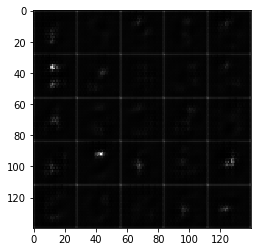

Epoch 1/2... Discriminator Loss: 1.616807... Generator Loss: 0.489754
Epoch 1/2... Discriminator Loss: 1.120325... Generator Loss: 0.868564
Epoch 1/2... Discriminator Loss: 1.678657... Generator Loss: 0.443445
Epoch 1/2... Discriminator Loss: 1.427514... Generator Loss: 0.773384
Epoch 1/2... Discriminator Loss: 2.004548... Generator Loss: 0.360184
Epoch 1/2... Discriminator Loss: 1.858418... Generator Loss: 0.507325
Epoch 1/2... Discriminator Loss: 1.904109... Generator Loss: 0.633020
Epoch 1/2... Discriminator Loss: 1.828262... Generator Loss: 0.426474
Epoch 1/2... Discriminator Loss: 1.618709... Generator Loss: 0.977600
Epoch 1/2... Discriminator Loss: 1.477351... Generator Loss: 1.079621


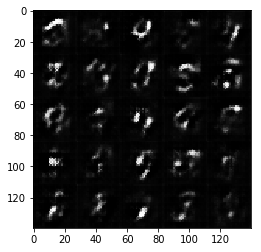

Epoch 1/2... Discriminator Loss: 1.337587... Generator Loss: 1.175368
Epoch 1/2... Discriminator Loss: 1.456893... Generator Loss: 0.754940
Epoch 1/2... Discriminator Loss: 1.598367... Generator Loss: 0.753609
Epoch 1/2... Discriminator Loss: 1.326171... Generator Loss: 1.120418
Epoch 1/2... Discriminator Loss: 1.397080... Generator Loss: 1.112900
Epoch 1/2... Discriminator Loss: 1.361630... Generator Loss: 0.616594
Epoch 1/2... Discriminator Loss: 1.383860... Generator Loss: 0.594966
Epoch 1/2... Discriminator Loss: 1.321370... Generator Loss: 0.955693
Epoch 1/2... Discriminator Loss: 1.264509... Generator Loss: 0.931917
Epoch 1/2... Discriminator Loss: 1.295663... Generator Loss: 0.723153


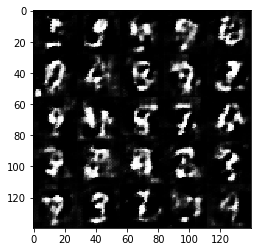

Epoch 1/2... Discriminator Loss: 1.268613... Generator Loss: 0.791374
Epoch 1/2... Discriminator Loss: 1.273000... Generator Loss: 0.904543
Epoch 1/2... Discriminator Loss: 1.299578... Generator Loss: 0.971852
Epoch 1/2... Discriminator Loss: 1.475299... Generator Loss: 0.526031
Epoch 1/2... Discriminator Loss: 1.228592... Generator Loss: 1.081907
Epoch 1/2... Discriminator Loss: 1.228035... Generator Loss: 1.145880
Epoch 1/2... Discriminator Loss: 1.266239... Generator Loss: 1.202521
Epoch 1/2... Discriminator Loss: 1.285578... Generator Loss: 0.877332
Epoch 1/2... Discriminator Loss: 1.290588... Generator Loss: 1.308473
Epoch 1/2... Discriminator Loss: 1.141034... Generator Loss: 1.002514


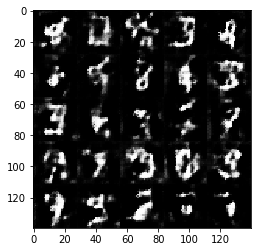

Epoch 1/2... Discriminator Loss: 1.161892... Generator Loss: 0.970039
Epoch 1/2... Discriminator Loss: 1.280092... Generator Loss: 1.197919
Epoch 1/2... Discriminator Loss: 1.180978... Generator Loss: 0.855788
Epoch 1/2... Discriminator Loss: 1.214297... Generator Loss: 0.933060
Epoch 1/2... Discriminator Loss: 1.210048... Generator Loss: 0.977454
Epoch 1/2... Discriminator Loss: 1.201028... Generator Loss: 1.046418
Epoch 1/2... Discriminator Loss: 1.200226... Generator Loss: 0.879454
Epoch 1/2... Discriminator Loss: 1.208133... Generator Loss: 1.181158
Epoch 1/2... Discriminator Loss: 1.265458... Generator Loss: 0.706561
Epoch 1/2... Discriminator Loss: 1.086453... Generator Loss: 1.166914


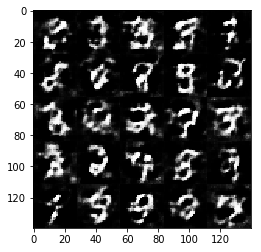

Epoch 1/2... Discriminator Loss: 1.109491... Generator Loss: 1.199598
Epoch 1/2... Discriminator Loss: 1.260995... Generator Loss: 0.991275
Epoch 1/2... Discriminator Loss: 1.248378... Generator Loss: 0.711213
Epoch 1/2... Discriminator Loss: 1.207990... Generator Loss: 1.437322
Epoch 1/2... Discriminator Loss: 1.169435... Generator Loss: 0.912226
Epoch 1/2... Discriminator Loss: 1.278216... Generator Loss: 0.648664
Epoch 1/2... Discriminator Loss: 1.442849... Generator Loss: 2.041167
Epoch 1/2... Discriminator Loss: 1.234028... Generator Loss: 1.449169
Epoch 1/2... Discriminator Loss: 1.306191... Generator Loss: 0.703322
Epoch 1/2... Discriminator Loss: 1.232631... Generator Loss: 0.853611


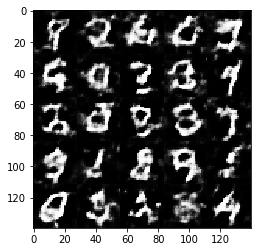

Epoch 1/2... Discriminator Loss: 1.149362... Generator Loss: 1.078648
Epoch 1/2... Discriminator Loss: 1.178891... Generator Loss: 0.870130
Epoch 1/2... Discriminator Loss: 1.190785... Generator Loss: 0.933105
Epoch 1/2... Discriminator Loss: 1.294338... Generator Loss: 0.724544
Epoch 1/2... Discriminator Loss: 1.362862... Generator Loss: 0.554062
Epoch 1/2... Discriminator Loss: 1.367646... Generator Loss: 0.892632
Epoch 1/2... Discriminator Loss: 1.190593... Generator Loss: 1.157064
Epoch 1/2... Discriminator Loss: 1.492335... Generator Loss: 1.407321
Epoch 1/2... Discriminator Loss: 1.244812... Generator Loss: 0.884125
Epoch 1/2... Discriminator Loss: 1.162545... Generator Loss: 0.795309


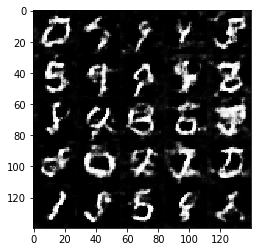

Epoch 1/2... Discriminator Loss: 1.233890... Generator Loss: 1.030610
Epoch 1/2... Discriminator Loss: 1.277705... Generator Loss: 0.910904
Epoch 1/2... Discriminator Loss: 1.311037... Generator Loss: 0.622325
Epoch 1/2... Discriminator Loss: 1.337368... Generator Loss: 0.663594
Epoch 1/2... Discriminator Loss: 1.236187... Generator Loss: 1.088006
Epoch 1/2... Discriminator Loss: 1.323785... Generator Loss: 0.699409
Epoch 1/2... Discriminator Loss: 1.243572... Generator Loss: 1.106084
Epoch 1/2... Discriminator Loss: 1.276002... Generator Loss: 0.698848
Epoch 1/2... Discriminator Loss: 1.312869... Generator Loss: 1.089733
Epoch 1/2... Discriminator Loss: 1.373697... Generator Loss: 0.584159


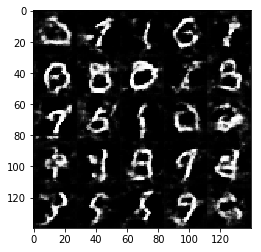

Epoch 1/2... Discriminator Loss: 1.366182... Generator Loss: 0.955466
Epoch 1/2... Discriminator Loss: 1.253179... Generator Loss: 0.955650
Epoch 1/2... Discriminator Loss: 1.291177... Generator Loss: 1.202803
Epoch 1/2... Discriminator Loss: 1.402424... Generator Loss: 0.670007
Epoch 1/2... Discriminator Loss: 1.287793... Generator Loss: 1.040646
Epoch 1/2... Discriminator Loss: 1.186101... Generator Loss: 0.962819
Epoch 1/2... Discriminator Loss: 1.235456... Generator Loss: 0.998088
Epoch 1/2... Discriminator Loss: 1.350926... Generator Loss: 1.138672
Epoch 1/2... Discriminator Loss: 1.326164... Generator Loss: 1.317704
Epoch 1/2... Discriminator Loss: 1.293716... Generator Loss: 0.699609


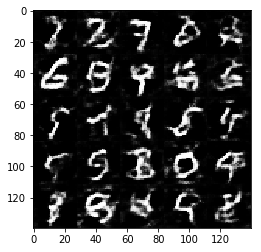

Epoch 1/2... Discriminator Loss: 1.314202... Generator Loss: 0.726730
Epoch 1/2... Discriminator Loss: 1.284674... Generator Loss: 0.840914
Epoch 1/2... Discriminator Loss: 1.278263... Generator Loss: 1.238579
Epoch 2/2... Discriminator Loss: 1.292409... Generator Loss: 0.725451
Epoch 2/2... Discriminator Loss: 1.306742... Generator Loss: 0.854122
Epoch 2/2... Discriminator Loss: 1.208513... Generator Loss: 1.131236
Epoch 2/2... Discriminator Loss: 1.297627... Generator Loss: 1.086114
Epoch 2/2... Discriminator Loss: 1.315135... Generator Loss: 0.816817
Epoch 2/2... Discriminator Loss: 1.240197... Generator Loss: 0.873984
Epoch 2/2... Discriminator Loss: 1.313058... Generator Loss: 1.017040


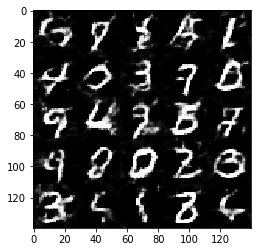

Epoch 2/2... Discriminator Loss: 1.206082... Generator Loss: 1.109372
Epoch 2/2... Discriminator Loss: 1.326691... Generator Loss: 0.894326
Epoch 2/2... Discriminator Loss: 1.249664... Generator Loss: 1.030345
Epoch 2/2... Discriminator Loss: 1.331276... Generator Loss: 0.766755
Epoch 2/2... Discriminator Loss: 1.268658... Generator Loss: 0.765979
Epoch 2/2... Discriminator Loss: 1.206114... Generator Loss: 0.989644
Epoch 2/2... Discriminator Loss: 1.363344... Generator Loss: 0.670663
Epoch 2/2... Discriminator Loss: 1.316238... Generator Loss: 0.929213
Epoch 2/2... Discriminator Loss: 1.220045... Generator Loss: 1.066339
Epoch 2/2... Discriminator Loss: 1.370956... Generator Loss: 0.686874


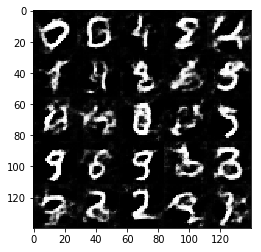

Epoch 2/2... Discriminator Loss: 1.263507... Generator Loss: 0.944852
Epoch 2/2... Discriminator Loss: 1.243724... Generator Loss: 0.866279
Epoch 2/2... Discriminator Loss: 1.210151... Generator Loss: 1.017054
Epoch 2/2... Discriminator Loss: 1.353273... Generator Loss: 0.652580
Epoch 2/2... Discriminator Loss: 1.256219... Generator Loss: 0.754257
Epoch 2/2... Discriminator Loss: 1.257228... Generator Loss: 0.943305
Epoch 2/2... Discriminator Loss: 1.329116... Generator Loss: 1.213905
Epoch 2/2... Discriminator Loss: 1.181872... Generator Loss: 0.862731
Epoch 2/2... Discriminator Loss: 1.416423... Generator Loss: 0.602171
Epoch 2/2... Discriminator Loss: 1.298128... Generator Loss: 0.844029


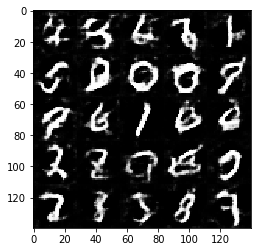

Epoch 2/2... Discriminator Loss: 1.299437... Generator Loss: 1.029978
Epoch 2/2... Discriminator Loss: 1.350428... Generator Loss: 0.701122
Epoch 2/2... Discriminator Loss: 1.445757... Generator Loss: 0.573555
Epoch 2/2... Discriminator Loss: 1.234786... Generator Loss: 0.874178
Epoch 2/2... Discriminator Loss: 1.316869... Generator Loss: 0.767188
Epoch 2/2... Discriminator Loss: 1.318549... Generator Loss: 0.958460
Epoch 2/2... Discriminator Loss: 1.287637... Generator Loss: 0.943298
Epoch 2/2... Discriminator Loss: 1.335882... Generator Loss: 0.822381
Epoch 2/2... Discriminator Loss: 1.282128... Generator Loss: 0.772061
Epoch 2/2... Discriminator Loss: 1.289439... Generator Loss: 1.001425


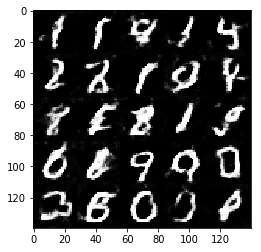

Epoch 2/2... Discriminator Loss: 1.268753... Generator Loss: 0.926232
Epoch 2/2... Discriminator Loss: 1.376247... Generator Loss: 0.716071
Epoch 2/2... Discriminator Loss: 1.314283... Generator Loss: 0.740921
Epoch 2/2... Discriminator Loss: 1.284738... Generator Loss: 0.919298
Epoch 2/2... Discriminator Loss: 1.339964... Generator Loss: 1.280048
Epoch 2/2... Discriminator Loss: 1.323718... Generator Loss: 1.079909
Epoch 2/2... Discriminator Loss: 1.266152... Generator Loss: 0.857886
Epoch 2/2... Discriminator Loss: 1.274389... Generator Loss: 0.706837
Epoch 2/2... Discriminator Loss: 1.381768... Generator Loss: 1.294416
Epoch 2/2... Discriminator Loss: 1.264204... Generator Loss: 1.232714


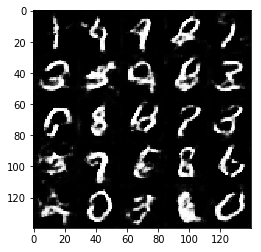

Epoch 2/2... Discriminator Loss: 1.275144... Generator Loss: 0.770662


KeyboardInterrupt: 

In [29]:
#kernel=5, alpha=0.08, smoothing=0.9
# batch_size = 64
# z_dim = 100
# learning_rate = 0.0002
# beta1 = 0.3

#kernel=5, alpha=0.15, smoothing=0.9
# batch_size = 64
# z_dim = 100
# learning_rate = 0.0002
# beta1 = 0.4

#kernel_size=3, alpha=0.15
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

tf.reset_default_graph()

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.575481... Generator Loss: 2.430450
Epoch 1/1... Discriminator Loss: 0.384441... Generator Loss: 5.603046
Epoch 1/1... Discriminator Loss: 0.373058... Generator Loss: 7.642376
Epoch 1/1... Discriminator Loss: 0.438193... Generator Loss: 13.257929
Epoch 1/1... Discriminator Loss: 0.383779... Generator Loss: 13.221723
Epoch 1/1... Discriminator Loss: 0.515604... Generator Loss: 11.736316
Epoch 1/1... Discriminator Loss: 0.599380... Generator Loss: 2.171259
Epoch 1/1... Discriminator Loss: 0.918353... Generator Loss: 2.491463
Epoch 1/1... Discriminator Loss: 0.894684... Generator Loss: 1.318589
Epoch 1/1... Discriminator Loss: 1.310325... Generator Loss: 0.738496


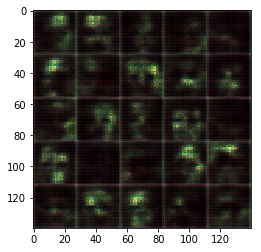

Epoch 1/1... Discriminator Loss: 1.081627... Generator Loss: 0.836198
Epoch 1/1... Discriminator Loss: 1.139199... Generator Loss: 0.923975
Epoch 1/1... Discriminator Loss: 0.839952... Generator Loss: 1.681114
Epoch 1/1... Discriminator Loss: 2.778581... Generator Loss: 0.204662
Epoch 1/1... Discriminator Loss: 0.650594... Generator Loss: 2.033247
Epoch 1/1... Discriminator Loss: 0.799103... Generator Loss: 2.971920
Epoch 1/1... Discriminator Loss: 0.847023... Generator Loss: 2.406251
Epoch 1/1... Discriminator Loss: 2.487341... Generator Loss: 5.374483
Epoch 1/1... Discriminator Loss: 1.155310... Generator Loss: 2.181493
Epoch 1/1... Discriminator Loss: 1.041966... Generator Loss: 1.703866


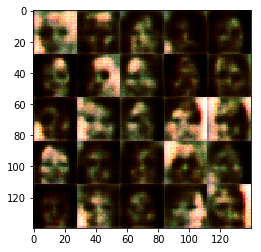

Epoch 1/1... Discriminator Loss: 2.058041... Generator Loss: 3.795676
Epoch 1/1... Discriminator Loss: 1.287989... Generator Loss: 1.368695
Epoch 1/1... Discriminator Loss: 1.150598... Generator Loss: 0.866887
Epoch 1/1... Discriminator Loss: 0.829203... Generator Loss: 1.482797
Epoch 1/1... Discriminator Loss: 0.991221... Generator Loss: 2.020607
Epoch 1/1... Discriminator Loss: 1.547907... Generator Loss: 0.625468
Epoch 1/1... Discriminator Loss: 1.465570... Generator Loss: 3.540314
Epoch 1/1... Discriminator Loss: 1.445608... Generator Loss: 0.529455
Epoch 1/1... Discriminator Loss: 1.328198... Generator Loss: 0.601469
Epoch 1/1... Discriminator Loss: 0.993266... Generator Loss: 2.024822


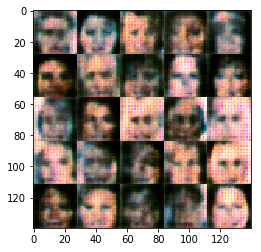

Epoch 1/1... Discriminator Loss: 1.645074... Generator Loss: 0.505226
Epoch 1/1... Discriminator Loss: 1.404641... Generator Loss: 1.651264
Epoch 1/1... Discriminator Loss: 1.243845... Generator Loss: 0.881191
Epoch 1/1... Discriminator Loss: 1.214109... Generator Loss: 0.743602
Epoch 1/1... Discriminator Loss: 1.129213... Generator Loss: 1.030772
Epoch 1/1... Discriminator Loss: 1.396057... Generator Loss: 1.758264
Epoch 1/1... Discriminator Loss: 1.095072... Generator Loss: 1.460145
Epoch 1/1... Discriminator Loss: 1.249669... Generator Loss: 1.603491
Epoch 1/1... Discriminator Loss: 1.226473... Generator Loss: 1.635902
Epoch 1/1... Discriminator Loss: 1.424421... Generator Loss: 0.578771


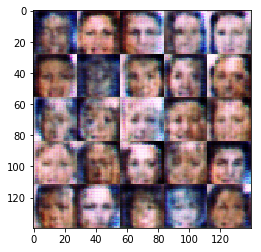

Epoch 1/1... Discriminator Loss: 1.171763... Generator Loss: 1.011707
Epoch 1/1... Discriminator Loss: 1.565120... Generator Loss: 1.704864
Epoch 1/1... Discriminator Loss: 1.254933... Generator Loss: 1.650120
Epoch 1/1... Discriminator Loss: 1.899671... Generator Loss: 0.339899
Epoch 1/1... Discriminator Loss: 1.410606... Generator Loss: 0.695310
Epoch 1/1... Discriminator Loss: 1.486865... Generator Loss: 0.679727
Epoch 1/1... Discriminator Loss: 1.261104... Generator Loss: 1.551842
Epoch 1/1... Discriminator Loss: 1.192890... Generator Loss: 1.471562
Epoch 1/1... Discriminator Loss: 1.482985... Generator Loss: 0.810231
Epoch 1/1... Discriminator Loss: 1.530050... Generator Loss: 0.651993


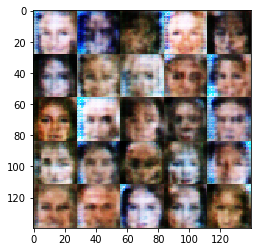

Epoch 1/1... Discriminator Loss: 1.329163... Generator Loss: 1.131666
Epoch 1/1... Discriminator Loss: 1.618593... Generator Loss: 0.554333
Epoch 1/1... Discriminator Loss: 1.230170... Generator Loss: 0.958128
Epoch 1/1... Discriminator Loss: 1.456573... Generator Loss: 0.883179
Epoch 1/1... Discriminator Loss: 1.405558... Generator Loss: 0.645825
Epoch 1/1... Discriminator Loss: 1.314677... Generator Loss: 0.734188
Epoch 1/1... Discriminator Loss: 1.516639... Generator Loss: 1.060869
Epoch 1/1... Discriminator Loss: 1.599085... Generator Loss: 0.573405
Epoch 1/1... Discriminator Loss: 1.542265... Generator Loss: 0.686890
Epoch 1/1... Discriminator Loss: 1.477318... Generator Loss: 0.833372


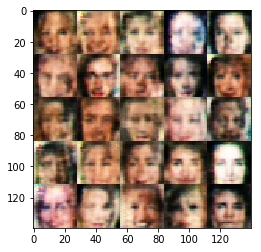

Epoch 1/1... Discriminator Loss: 1.387022... Generator Loss: 0.747270
Epoch 1/1... Discriminator Loss: 1.596547... Generator Loss: 0.859038
Epoch 1/1... Discriminator Loss: 1.642599... Generator Loss: 0.768723
Epoch 1/1... Discriminator Loss: 1.580902... Generator Loss: 0.729556
Epoch 1/1... Discriminator Loss: 1.678292... Generator Loss: 0.489567
Epoch 1/1... Discriminator Loss: 1.395294... Generator Loss: 1.067623
Epoch 1/1... Discriminator Loss: 1.763529... Generator Loss: 0.834858
Epoch 1/1... Discriminator Loss: 1.332336... Generator Loss: 0.903646
Epoch 1/1... Discriminator Loss: 1.624889... Generator Loss: 0.646277
Epoch 1/1... Discriminator Loss: 1.324051... Generator Loss: 0.906301


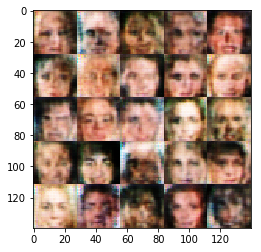

Epoch 1/1... Discriminator Loss: 1.589685... Generator Loss: 0.794464
Epoch 1/1... Discriminator Loss: 1.431827... Generator Loss: 0.738397
Epoch 1/1... Discriminator Loss: 1.524746... Generator Loss: 0.827619
Epoch 1/1... Discriminator Loss: 1.434703... Generator Loss: 0.665085
Epoch 1/1... Discriminator Loss: 1.623901... Generator Loss: 0.502497
Epoch 1/1... Discriminator Loss: 1.253809... Generator Loss: 0.844629
Epoch 1/1... Discriminator Loss: 1.444042... Generator Loss: 0.844611
Epoch 1/1... Discriminator Loss: 1.516581... Generator Loss: 0.657655
Epoch 1/1... Discriminator Loss: 1.461624... Generator Loss: 0.588833
Epoch 1/1... Discriminator Loss: 1.666462... Generator Loss: 0.925037


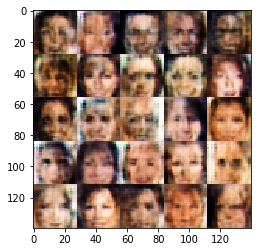

Epoch 1/1... Discriminator Loss: 1.453806... Generator Loss: 0.607137
Epoch 1/1... Discriminator Loss: 1.442917... Generator Loss: 0.807947
Epoch 1/1... Discriminator Loss: 1.449203... Generator Loss: 0.577510
Epoch 1/1... Discriminator Loss: 1.296672... Generator Loss: 0.881490
Epoch 1/1... Discriminator Loss: 1.419104... Generator Loss: 0.791056
Epoch 1/1... Discriminator Loss: 1.427829... Generator Loss: 1.068757
Epoch 1/1... Discriminator Loss: 1.468175... Generator Loss: 0.836182
Epoch 1/1... Discriminator Loss: 1.479406... Generator Loss: 0.556626
Epoch 1/1... Discriminator Loss: 1.372705... Generator Loss: 0.632422
Epoch 1/1... Discriminator Loss: 1.268614... Generator Loss: 1.132217


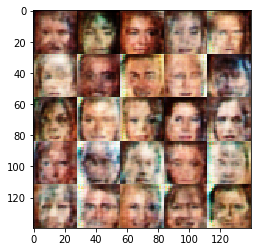

Epoch 1/1... Discriminator Loss: 1.313029... Generator Loss: 1.019058
Epoch 1/1... Discriminator Loss: 1.466830... Generator Loss: 0.826347
Epoch 1/1... Discriminator Loss: 1.496632... Generator Loss: 1.027861
Epoch 1/1... Discriminator Loss: 1.512199... Generator Loss: 0.546225
Epoch 1/1... Discriminator Loss: 1.466209... Generator Loss: 0.652493
Epoch 1/1... Discriminator Loss: 1.694773... Generator Loss: 0.729246
Epoch 1/1... Discriminator Loss: 1.427135... Generator Loss: 1.178415
Epoch 1/1... Discriminator Loss: 1.440405... Generator Loss: 1.049823
Epoch 1/1... Discriminator Loss: 1.448988... Generator Loss: 0.838193
Epoch 1/1... Discriminator Loss: 1.293652... Generator Loss: 0.967093


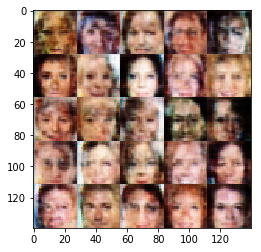

Epoch 1/1... Discriminator Loss: 1.450037... Generator Loss: 0.776728
Epoch 1/1... Discriminator Loss: 2.130026... Generator Loss: 1.925738
Epoch 1/1... Discriminator Loss: 1.276905... Generator Loss: 0.981556
Epoch 1/1... Discriminator Loss: 1.406990... Generator Loss: 0.804627
Epoch 1/1... Discriminator Loss: 1.328582... Generator Loss: 0.815946
Epoch 1/1... Discriminator Loss: 1.314173... Generator Loss: 0.817032
Epoch 1/1... Discriminator Loss: 1.593735... Generator Loss: 0.608744
Epoch 1/1... Discriminator Loss: 1.524252... Generator Loss: 0.895934
Epoch 1/1... Discriminator Loss: 1.380075... Generator Loss: 0.650516
Epoch 1/1... Discriminator Loss: 1.498275... Generator Loss: 0.992219


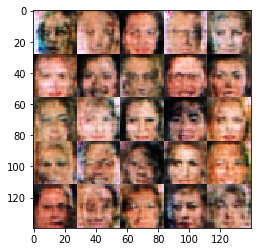

Epoch 1/1... Discriminator Loss: 1.341381... Generator Loss: 0.925772
Epoch 1/1... Discriminator Loss: 1.403634... Generator Loss: 0.774737
Epoch 1/1... Discriminator Loss: 1.452496... Generator Loss: 0.783631
Epoch 1/1... Discriminator Loss: 1.450374... Generator Loss: 0.622277
Epoch 1/1... Discriminator Loss: 1.328393... Generator Loss: 0.714547
Epoch 1/1... Discriminator Loss: 1.344494... Generator Loss: 0.745699
Epoch 1/1... Discriminator Loss: 1.442392... Generator Loss: 0.730914
Epoch 1/1... Discriminator Loss: 1.307239... Generator Loss: 1.174195
Epoch 1/1... Discriminator Loss: 1.396518... Generator Loss: 0.559510
Epoch 1/1... Discriminator Loss: 1.351474... Generator Loss: 0.733396


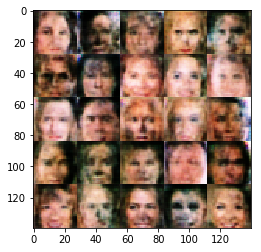

Epoch 1/1... Discriminator Loss: 1.469511... Generator Loss: 0.583893
Epoch 1/1... Discriminator Loss: 1.363686... Generator Loss: 0.802481
Epoch 1/1... Discriminator Loss: 1.382152... Generator Loss: 0.569653
Epoch 1/1... Discriminator Loss: 1.305873... Generator Loss: 0.867811
Epoch 1/1... Discriminator Loss: 1.544367... Generator Loss: 1.295139
Epoch 1/1... Discriminator Loss: 1.527153... Generator Loss: 1.279219
Epoch 1/1... Discriminator Loss: 1.344672... Generator Loss: 0.781422
Epoch 1/1... Discriminator Loss: 1.294510... Generator Loss: 0.895310
Epoch 1/1... Discriminator Loss: 1.341966... Generator Loss: 0.759126
Epoch 1/1... Discriminator Loss: 1.424995... Generator Loss: 0.593247


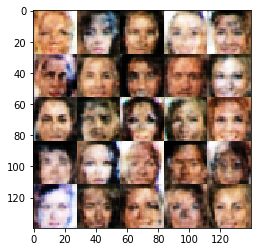

Epoch 1/1... Discriminator Loss: 1.517608... Generator Loss: 1.103642
Epoch 1/1... Discriminator Loss: 1.471136... Generator Loss: 0.893866
Epoch 1/1... Discriminator Loss: 1.365633... Generator Loss: 0.864948
Epoch 1/1... Discriminator Loss: 1.338211... Generator Loss: 1.031027
Epoch 1/1... Discriminator Loss: 1.312824... Generator Loss: 0.719957
Epoch 1/1... Discriminator Loss: 1.389877... Generator Loss: 0.676982
Epoch 1/1... Discriminator Loss: 1.445740... Generator Loss: 1.020089
Epoch 1/1... Discriminator Loss: 1.451772... Generator Loss: 0.575561
Epoch 1/1... Discriminator Loss: 1.347910... Generator Loss: 0.776228
Epoch 1/1... Discriminator Loss: 1.278208... Generator Loss: 1.083891


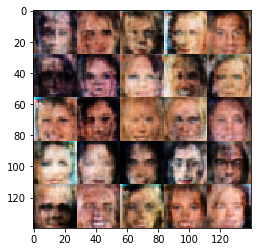

Epoch 1/1... Discriminator Loss: 1.405197... Generator Loss: 0.749595
Epoch 1/1... Discriminator Loss: 1.332127... Generator Loss: 0.855133
Epoch 1/1... Discriminator Loss: 1.511585... Generator Loss: 0.540900
Epoch 1/1... Discriminator Loss: 1.289728... Generator Loss: 1.217059
Epoch 1/1... Discriminator Loss: 1.443127... Generator Loss: 0.827536
Epoch 1/1... Discriminator Loss: 1.222139... Generator Loss: 0.792365
Epoch 1/1... Discriminator Loss: 1.426212... Generator Loss: 0.806452
Epoch 1/1... Discriminator Loss: 1.317294... Generator Loss: 0.804678
Epoch 1/1... Discriminator Loss: 1.386881... Generator Loss: 0.993383
Epoch 1/1... Discriminator Loss: 1.292341... Generator Loss: 0.843314


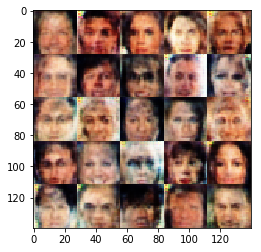

Epoch 1/1... Discriminator Loss: 1.484651... Generator Loss: 1.127630
Epoch 1/1... Discriminator Loss: 1.372568... Generator Loss: 0.968848
Epoch 1/1... Discriminator Loss: 1.316239... Generator Loss: 0.916040
Epoch 1/1... Discriminator Loss: 1.413526... Generator Loss: 0.880556
Epoch 1/1... Discriminator Loss: 1.538009... Generator Loss: 0.483140
Epoch 1/1... Discriminator Loss: 1.368977... Generator Loss: 0.696694
Epoch 1/1... Discriminator Loss: 1.282249... Generator Loss: 0.845883
Epoch 1/1... Discriminator Loss: 1.490575... Generator Loss: 0.588051
Epoch 1/1... Discriminator Loss: 1.324574... Generator Loss: 0.985274
Epoch 1/1... Discriminator Loss: 1.311472... Generator Loss: 0.792969


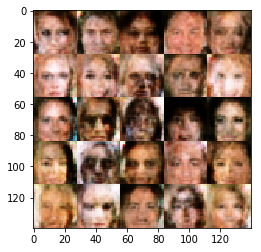

Epoch 1/1... Discriminator Loss: 1.393242... Generator Loss: 0.631434
Epoch 1/1... Discriminator Loss: 1.393265... Generator Loss: 1.155453
Epoch 1/1... Discriminator Loss: 1.441972... Generator Loss: 0.946794
Epoch 1/1... Discriminator Loss: 1.321516... Generator Loss: 0.897298
Epoch 1/1... Discriminator Loss: 1.300701... Generator Loss: 0.802065
Epoch 1/1... Discriminator Loss: 1.278535... Generator Loss: 0.855269
Epoch 1/1... Discriminator Loss: 1.355064... Generator Loss: 0.788567
Epoch 1/1... Discriminator Loss: 1.391789... Generator Loss: 0.763752
Epoch 1/1... Discriminator Loss: 1.231241... Generator Loss: 1.070122
Epoch 1/1... Discriminator Loss: 1.560792... Generator Loss: 1.077019


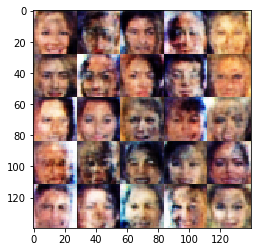

Epoch 1/1... Discriminator Loss: 1.307874... Generator Loss: 0.988994
Epoch 1/1... Discriminator Loss: 1.363302... Generator Loss: 0.965783
Epoch 1/1... Discriminator Loss: 1.365802... Generator Loss: 0.709876
Epoch 1/1... Discriminator Loss: 1.377926... Generator Loss: 0.724507
Epoch 1/1... Discriminator Loss: 1.264850... Generator Loss: 0.858878
Epoch 1/1... Discriminator Loss: 1.268471... Generator Loss: 0.829240
Epoch 1/1... Discriminator Loss: 1.244405... Generator Loss: 0.910439
Epoch 1/1... Discriminator Loss: 1.342490... Generator Loss: 0.784695
Epoch 1/1... Discriminator Loss: 1.365235... Generator Loss: 0.899217
Epoch 1/1... Discriminator Loss: 1.267674... Generator Loss: 0.875939


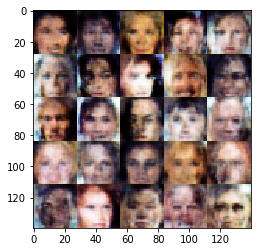

Epoch 1/1... Discriminator Loss: 1.446448... Generator Loss: 1.068293
Epoch 1/1... Discriminator Loss: 1.466570... Generator Loss: 0.954643
Epoch 1/1... Discriminator Loss: 1.352741... Generator Loss: 0.981418
Epoch 1/1... Discriminator Loss: 1.261039... Generator Loss: 0.898369
Epoch 1/1... Discriminator Loss: 1.494028... Generator Loss: 0.647268
Epoch 1/1... Discriminator Loss: 1.369853... Generator Loss: 0.887729
Epoch 1/1... Discriminator Loss: 1.318573... Generator Loss: 0.958018
Epoch 1/1... Discriminator Loss: 1.317970... Generator Loss: 1.067529
Epoch 1/1... Discriminator Loss: 1.430601... Generator Loss: 0.667425
Epoch 1/1... Discriminator Loss: 1.336131... Generator Loss: 0.876219


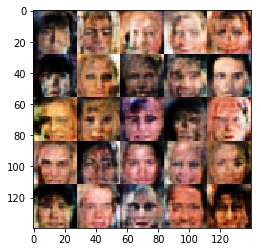

Epoch 1/1... Discriminator Loss: 1.362832... Generator Loss: 1.190035
Epoch 1/1... Discriminator Loss: 1.228396... Generator Loss: 1.163429
Epoch 1/1... Discriminator Loss: 1.424920... Generator Loss: 0.677867
Epoch 1/1... Discriminator Loss: 1.427749... Generator Loss: 0.758984
Epoch 1/1... Discriminator Loss: 1.483862... Generator Loss: 1.000196
Epoch 1/1... Discriminator Loss: 1.292182... Generator Loss: 0.702280
Epoch 1/1... Discriminator Loss: 1.534182... Generator Loss: 1.506876
Epoch 1/1... Discriminator Loss: 1.480484... Generator Loss: 0.617146
Epoch 1/1... Discriminator Loss: 1.331987... Generator Loss: 0.858224
Epoch 1/1... Discriminator Loss: 1.242887... Generator Loss: 0.876746


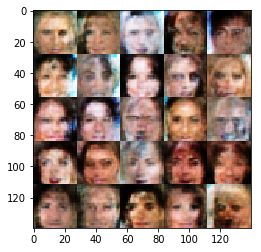

Epoch 1/1... Discriminator Loss: 1.341440... Generator Loss: 0.874101
Epoch 1/1... Discriminator Loss: 1.354354... Generator Loss: 0.719697
Epoch 1/1... Discriminator Loss: 1.324582... Generator Loss: 0.934221
Epoch 1/1... Discriminator Loss: 1.232504... Generator Loss: 1.104900
Epoch 1/1... Discriminator Loss: 1.335311... Generator Loss: 0.950641
Epoch 1/1... Discriminator Loss: 1.437786... Generator Loss: 0.989213
Epoch 1/1... Discriminator Loss: 1.372984... Generator Loss: 0.772145
Epoch 1/1... Discriminator Loss: 1.375889... Generator Loss: 0.844173
Epoch 1/1... Discriminator Loss: 1.393582... Generator Loss: 1.155298
Epoch 1/1... Discriminator Loss: 1.409884... Generator Loss: 0.822871


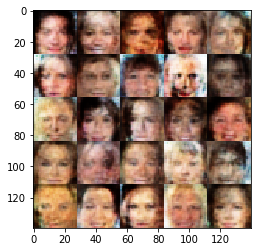

Epoch 1/1... Discriminator Loss: 1.315570... Generator Loss: 0.711393
Epoch 1/1... Discriminator Loss: 1.260449... Generator Loss: 0.787831
Epoch 1/1... Discriminator Loss: 1.277558... Generator Loss: 0.863296
Epoch 1/1... Discriminator Loss: 1.241209... Generator Loss: 0.846934
Epoch 1/1... Discriminator Loss: 1.244651... Generator Loss: 0.802423
Epoch 1/1... Discriminator Loss: 1.368029... Generator Loss: 0.775240
Epoch 1/1... Discriminator Loss: 1.286763... Generator Loss: 0.757038
Epoch 1/1... Discriminator Loss: 1.556417... Generator Loss: 0.474633
Epoch 1/1... Discriminator Loss: 1.359427... Generator Loss: 0.693968
Epoch 1/1... Discriminator Loss: 1.388697... Generator Loss: 1.006434


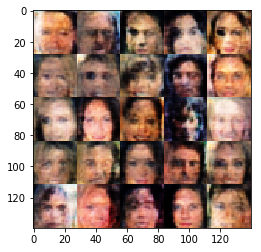

Epoch 1/1... Discriminator Loss: 1.355225... Generator Loss: 0.805918
Epoch 1/1... Discriminator Loss: 1.353361... Generator Loss: 0.759304
Epoch 1/1... Discriminator Loss: 1.333606... Generator Loss: 0.900125
Epoch 1/1... Discriminator Loss: 1.244848... Generator Loss: 0.914761
Epoch 1/1... Discriminator Loss: 1.360658... Generator Loss: 0.947288
Epoch 1/1... Discriminator Loss: 1.457399... Generator Loss: 1.248912
Epoch 1/1... Discriminator Loss: 1.305741... Generator Loss: 0.870388
Epoch 1/1... Discriminator Loss: 1.589399... Generator Loss: 1.391938
Epoch 1/1... Discriminator Loss: 1.296993... Generator Loss: 0.782740
Epoch 1/1... Discriminator Loss: 1.357245... Generator Loss: 0.794193


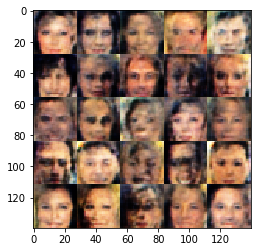

Epoch 1/1... Discriminator Loss: 1.343174... Generator Loss: 0.848683
Epoch 1/1... Discriminator Loss: 1.174830... Generator Loss: 0.880688
Epoch 1/1... Discriminator Loss: 1.381010... Generator Loss: 1.102069
Epoch 1/1... Discriminator Loss: 1.429505... Generator Loss: 0.717555
Epoch 1/1... Discriminator Loss: 1.309802... Generator Loss: 0.721532
Epoch 1/1... Discriminator Loss: 1.390267... Generator Loss: 0.993275
Epoch 1/1... Discriminator Loss: 1.215800... Generator Loss: 0.931729
Epoch 1/1... Discriminator Loss: 1.530401... Generator Loss: 0.485420
Epoch 1/1... Discriminator Loss: 1.473412... Generator Loss: 1.136457
Epoch 1/1... Discriminator Loss: 1.325650... Generator Loss: 0.883677


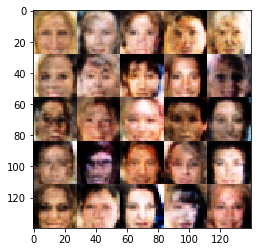

Epoch 1/1... Discriminator Loss: 1.207109... Generator Loss: 0.970325
Epoch 1/1... Discriminator Loss: 1.291164... Generator Loss: 0.792761
Epoch 1/1... Discriminator Loss: 1.312490... Generator Loss: 0.750875
Epoch 1/1... Discriminator Loss: 1.331843... Generator Loss: 0.926637
Epoch 1/1... Discriminator Loss: 1.230421... Generator Loss: 0.884161
Epoch 1/1... Discriminator Loss: 1.304166... Generator Loss: 0.872144
Epoch 1/1... Discriminator Loss: 1.331371... Generator Loss: 0.864320
Epoch 1/1... Discriminator Loss: 1.361957... Generator Loss: 0.740094
Epoch 1/1... Discriminator Loss: 1.473088... Generator Loss: 0.581310
Epoch 1/1... Discriminator Loss: 1.361352... Generator Loss: 1.011240


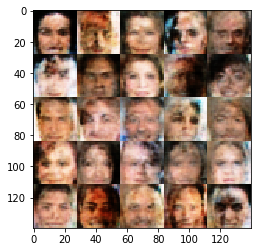

Epoch 1/1... Discriminator Loss: 1.339433... Generator Loss: 0.914697
Epoch 1/1... Discriminator Loss: 1.254321... Generator Loss: 0.912839
Epoch 1/1... Discriminator Loss: 1.453544... Generator Loss: 0.575371
Epoch 1/1... Discriminator Loss: 1.358165... Generator Loss: 0.670044
Epoch 1/1... Discriminator Loss: 1.414374... Generator Loss: 0.825863
Epoch 1/1... Discriminator Loss: 1.795587... Generator Loss: 2.016879
Epoch 1/1... Discriminator Loss: 1.468008... Generator Loss: 0.999318
Epoch 1/1... Discriminator Loss: 1.361815... Generator Loss: 0.819952
Epoch 1/1... Discriminator Loss: 1.348910... Generator Loss: 0.834658
Epoch 1/1... Discriminator Loss: 1.233825... Generator Loss: 0.978263


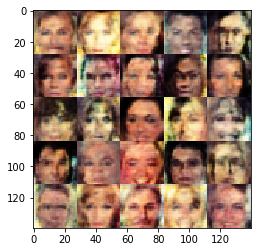

Epoch 1/1... Discriminator Loss: 1.443167... Generator Loss: 0.835742
Epoch 1/1... Discriminator Loss: 1.281660... Generator Loss: 0.976045
Epoch 1/1... Discriminator Loss: 1.335890... Generator Loss: 0.671911
Epoch 1/1... Discriminator Loss: 1.403553... Generator Loss: 0.761686
Epoch 1/1... Discriminator Loss: 1.417138... Generator Loss: 0.650218
Epoch 1/1... Discriminator Loss: 1.370147... Generator Loss: 1.122928
Epoch 1/1... Discriminator Loss: 1.424592... Generator Loss: 1.327420
Epoch 1/1... Discriminator Loss: 1.355158... Generator Loss: 0.768903
Epoch 1/1... Discriminator Loss: 1.349741... Generator Loss: 1.120951
Epoch 1/1... Discriminator Loss: 1.428722... Generator Loss: 0.618161


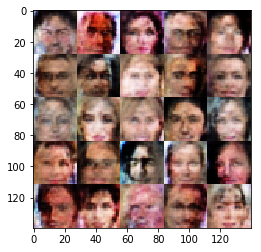

Epoch 1/1... Discriminator Loss: 1.437895... Generator Loss: 1.185284
Epoch 1/1... Discriminator Loss: 1.296519... Generator Loss: 0.963660
Epoch 1/1... Discriminator Loss: 1.376211... Generator Loss: 0.945057
Epoch 1/1... Discriminator Loss: 1.334859... Generator Loss: 1.035177
Epoch 1/1... Discriminator Loss: 1.341257... Generator Loss: 0.720684
Epoch 1/1... Discriminator Loss: 1.465668... Generator Loss: 0.581240
Epoch 1/1... Discriminator Loss: 1.462529... Generator Loss: 1.055366
Epoch 1/1... Discriminator Loss: 1.474051... Generator Loss: 0.535111
Epoch 1/1... Discriminator Loss: 1.389940... Generator Loss: 1.264590
Epoch 1/1... Discriminator Loss: 1.325807... Generator Loss: 0.658054


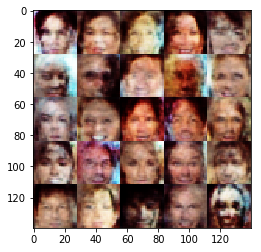

Epoch 1/1... Discriminator Loss: 1.353979... Generator Loss: 0.696538
Epoch 1/1... Discriminator Loss: 1.271566... Generator Loss: 0.770753
Epoch 1/1... Discriminator Loss: 1.287899... Generator Loss: 0.973064
Epoch 1/1... Discriminator Loss: 1.298155... Generator Loss: 0.919409
Epoch 1/1... Discriminator Loss: 1.319517... Generator Loss: 0.795906
Epoch 1/1... Discriminator Loss: 1.365332... Generator Loss: 0.640398
Epoch 1/1... Discriminator Loss: 1.305589... Generator Loss: 0.871132
Epoch 1/1... Discriminator Loss: 1.422971... Generator Loss: 0.607361
Epoch 1/1... Discriminator Loss: 1.502642... Generator Loss: 0.489594
Epoch 1/1... Discriminator Loss: 1.344415... Generator Loss: 0.668813


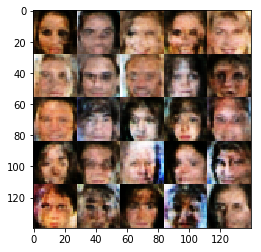

Epoch 1/1... Discriminator Loss: 1.229286... Generator Loss: 1.027533
Epoch 1/1... Discriminator Loss: 1.297574... Generator Loss: 0.984242
Epoch 1/1... Discriminator Loss: 1.324181... Generator Loss: 0.853185
Epoch 1/1... Discriminator Loss: 1.294888... Generator Loss: 1.033914
Epoch 1/1... Discriminator Loss: 1.337685... Generator Loss: 0.659929
Epoch 1/1... Discriminator Loss: 1.311401... Generator Loss: 0.834250
Epoch 1/1... Discriminator Loss: 1.283060... Generator Loss: 1.177616
Epoch 1/1... Discriminator Loss: 1.388142... Generator Loss: 0.904990
Epoch 1/1... Discriminator Loss: 1.327843... Generator Loss: 1.050231
Epoch 1/1... Discriminator Loss: 1.280147... Generator Loss: 0.771753


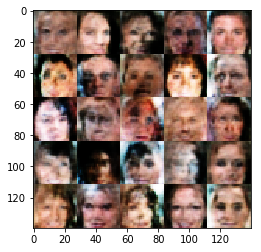

Epoch 1/1... Discriminator Loss: 1.379696... Generator Loss: 0.484121
Epoch 1/1... Discriminator Loss: 1.319538... Generator Loss: 0.707556
Epoch 1/1... Discriminator Loss: 1.398234... Generator Loss: 0.623839
Epoch 1/1... Discriminator Loss: 1.297697... Generator Loss: 1.147354
Epoch 1/1... Discriminator Loss: 1.310057... Generator Loss: 0.747957
Epoch 1/1... Discriminator Loss: 1.385547... Generator Loss: 0.759751
Epoch 1/1... Discriminator Loss: 1.316213... Generator Loss: 0.902748
Epoch 1/1... Discriminator Loss: 1.242867... Generator Loss: 0.999062
Epoch 1/1... Discriminator Loss: 1.400316... Generator Loss: 0.769602
Epoch 1/1... Discriminator Loss: 1.374583... Generator Loss: 0.894652


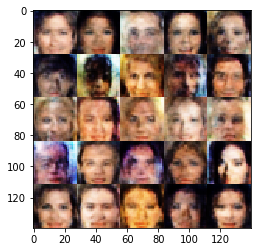

Epoch 1/1... Discriminator Loss: 1.353877... Generator Loss: 0.700373
Epoch 1/1... Discriminator Loss: 1.294042... Generator Loss: 1.065899
Epoch 1/1... Discriminator Loss: 1.370406... Generator Loss: 0.628571
Epoch 1/1... Discriminator Loss: 1.364641... Generator Loss: 0.710972
Epoch 1/1... Discriminator Loss: 1.377001... Generator Loss: 0.839727
Epoch 1/1... Discriminator Loss: 1.407116... Generator Loss: 0.579200


In [28]:
# batch_size = 128
# z_dim = 100
# learning_rate = 0.00002
# beta1 = 0.75

batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

tf.reset_default_graph()

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.